# Sentiment classification
### Marie BRUGUET, Victor PION and Loris BULLIARD
M2-EBDS /
DEC-2021

## Introduction to our project

Firms are interested to know customers, especially their feelings abouts products/services they sell to undertake actions to improve. 
Make a survey about customer satisfaction is relatively easy to treat as data but it has several drawback and can be costly (in time, design of a questionnaire is cumbersome, lot of bias (consumer and firm side (introspection bias)))
An alternative is to analyse social media comments to get “immediate reaction” (réaction à chaud). Unlike surveys, it’s hard to make simple descriptive stats from this kind of data (unstructured).

Goals/motivation:
Train a sentiment classifier on a first dataset and project it on a second dataset.
Interest for firms that have small datasets, can’t train a model with their own data. It is also costly to labelized data. Model already trained avoid this, if we can check on sample data. 
We will choose a pre-trained models, keep the weights, change the inputs vector and the output vector and do fine tuning. This way, we will benefits from transfer learning.
Try to summarize data by performing clustering to find topics, labelize them and examine their characteristics (negative sentiment)

A model trained on a first data set and projected on a second data set is interesting for companies that do not have a large enough data set to train their own model



# Imports

In [ ]:
import os, json, gzip 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import string
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('words')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import wordnet, stopwords

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


# Load data

In [ ]:
!wget http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Grocery_and_Gourmet_Food_5.json.gz

--2021-12-19 09:46:01--  http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Grocery_and_Gourmet_Food_5.json.gz
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 146631394 (140M) [application/octet-stream]
Saving to: ‘Grocery_and_Gourmet_Food_5.json.gz’

Grocery_and_Gourmet 100%[===================>] 139.84M  18.5MB/s    in 8.6s    

2021-12-19 09:46:10 (16.3 MB/s) - ‘Grocery_and_Gourmet_Food_5.json.gz’ saved [146631394/146631394]



In [ ]:
data = []

with gzip.open('Grocery_and_Gourmet_Food_5.json.gz') as f:

    for l in f:

        data.append(json.loads(l.strip()))

In [ ]:
df = pd.DataFrame.from_dict(data)

In [ ]:
len(df)

1143860

# Pre-preprocessing

In [ ]:
df = df.drop(['verified', 'summary', 'reviewTime', 'reviewerID', 'asin', 'reviewerName', 'unixReviewTime', 'vote', 'style', 'image'], axis = 1)

In [ ]:
df = df.dropna()

In [ ]:
df['text_length'] = df['reviewText'].str.len()

Text(0.5, 1.0, 'Text Length Distribution')

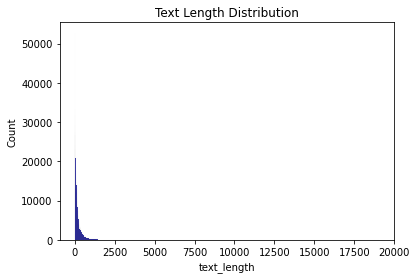

In [ ]:
sns.histplot(data=df, x='text_length', bins='auto', color='darkblue');
plt.title('Text Length Distribution')

In [ ]:
df = df[(df.text_length < 500) & (df.text_length > 10)]

Text(0.5, 1.0, 'Text Length Distribution')

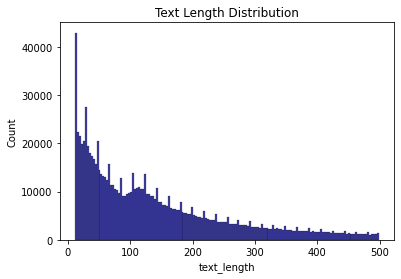

In [ ]:
sns.histplot(data=df, x='text_length', bins='auto', color='darkblue');
plt.title('Text Length Distribution')

In [ ]:
df = df.drop(['text_length'], axis = 1)

Text(0, 0.5, 'Count')

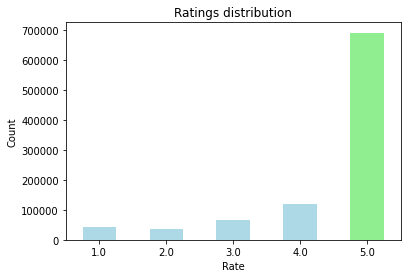

In [ ]:
df['overall'].value_counts().sort_index().plot.bar(title = "Ratings distribution", 
                                                   color = ["lightblue","lightblue","lightblue", "lightblue", "lightgreen"])
plt.xticks(rotation = 0, horizontalalignment = "center")
plt.xlabel("Rate")
plt.ylabel("Count")

In [ ]:
df['overall'] = df['overall'].replace({1: "Bad", 2:  "Bad", 3: "Neutral", 4: "Good", 5: "Good"})

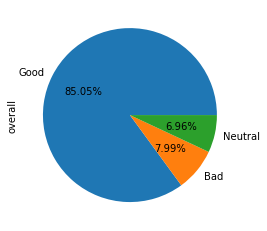

In [ ]:
df['overall'].value_counts().plot.pie(autopct='%1.2f%%')

In [ ]:
len(df)

953517

In [ ]:
df_bad = df[df.overall == "Bad"].sample(75000)
df_good = df[df.overall == "Good"].sample(75000)

In [ ]:
df = pd.concat([df_bad, df_good])

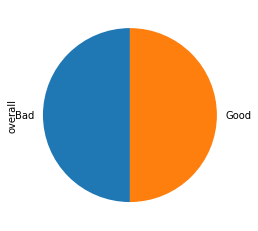

In [ ]:
df['overall'].value_counts().plot.pie(startangle = 90)

# Text cleaning

Preprocessing the reviews include lowercasing, removing punctuations and removing stopwords. Stopwords are insignificant informations that are frequent in texts such as "or", "to"... Removing them allows to reduce the dimension of the text vectors.

In [ ]:
stopwords_list = stopwords.words('english')

def ReviewProcessing(df):
  # remove non alphanumeric 
  df['review_cleaned'] = df.reviewText.str.replace('[^a-zA-Z0-9 ]', '')
  # lowercase
  df.review_cleaned = df.review_cleaned.str.lower()
  # split into list
  df.review_cleaned = df.review_cleaned.str.split(' ')
  # remove stopwords
  df.review_cleaned = df.review_cleaned.apply(lambda x: [item for item in x if item not in stopwords_list])
  return df

In [ ]:
df = ReviewProcessing(df)

In [ ]:
df.head()

,overall,reviewText,review_cleaned
845853,Bad,The Raspberry Truffle actually tastes like its...,"[raspberry, truffle, actually, tastes, like, n..."
28755,Bad,"This is a smokey type of tea, and I did not li...","[smokey, type, tea, like, taste, use, yorkshir..."
546603,Bad,"I am not happy with this at all, but It is my ...","[happy, fault, didnt, look, made, afraid, eat,..."
506689,Bad,"everyone tastes are different, but I don't thi...","[everyone, tastes, different, dont, think, goo..."
1044388,Bad,"These were good many years ago, but the last t...","[good, many, years, ago, last, two, orders, ta..."


# Lemmatization

Lemmatization corresponds to the process of reducing words to their root by removing the conjugations for example. "Throwing" will become "throw", and "thickened" will become "thicken". This process allows to reduce the number of words by simplifying them, which improves a lot models.

In [ ]:
def get_wordnet_pos(word):
  tag = nltk.pos_tag([word])[0][1][0].upper()
  tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

  return tag_dict.get(tag, wordnet.NOUN)

lemmatizer = nltk.stem.WordNetLemmatizer()
def get_lemmatize(sent):
  return " ".join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(sent)])

In [ ]:
%%time
df.review_cleaned = df.review_cleaned.apply(' '.join)
df['review_cleaned_lemmatized'] = df.review_cleaned.apply(get_lemmatize)

CPU times: user 6min 21s, sys: 17.5 s, total: 6min 38s
Wall time: 7min 1s


In [ ]:
df.head()

,overall,reviewText,review_cleaned,review_cleaned_lemmatized
656836,Bad,Chocolaty coating. Yuck. Whatever happened t...,chocolaty coating yuck whatever happened rea...,chocolaty coat yuck whatever happen real choco...
1090915,Bad,These were all melted together when they came ...,melted together came mail im still using would...,melt together come mail im still use would nev...
492130,Bad,I did not taste the garlic and these noodles h...,taste garlic noodles flavor plain greatly prefer,taste garlic noodle flavor plain greatly prefer
843455,Bad,These were awful!! No banana flavor at all. I ...,awful banana flavor eat paleo diet use artific...,awful banana flavor eat paleo diet use artific...
2175,Bad,This brand of tea felt stronger in the past. N...,brand tea felt stronger past feels ordinaryrel...,brand tea felt strong past feel ordinaryrelati...


In [ ]:
x = df['review_cleaned_lemmatized']
y = df['overall']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state = 44)

In [ ]:
logreg = Pipeline([('vect', CountVectorizer(ngram_range=(1, 2))),('tfidf', TfidfTransformer()),('clf', LogisticRegression(max_iter=500)),])

In [ ]:
%%time
logreg.fit(X_train, y_train)
y_pred_log = logreg.predict(X_test)
print("Accuracy score : " + str(accuracy_score(y_test, y_pred_log)))

Accuracy score : 0.8998666666666667
CPU times: user 19.7 s, sys: 7.72 s, total: 27.4 s
Wall time: 22 s


In [ ]:
print("Confusion matrix \n")
print(confusion_matrix(y_test, y_pred_log))

Confusion matrix 

[[13572  1428]
 [ 1576 13424]]


In [ ]:
print("Classification report \n")
print(classification_report(y_test, y_pred_log))

Classification report 

              precision    recall  f1-score   support

         Bad       0.90      0.90      0.90     15000
        Good       0.90      0.89      0.90     15000

    accuracy                           0.90     30000
   macro avg       0.90      0.90      0.90     30000
weighted avg       0.90      0.90      0.90     30000



In [ ]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

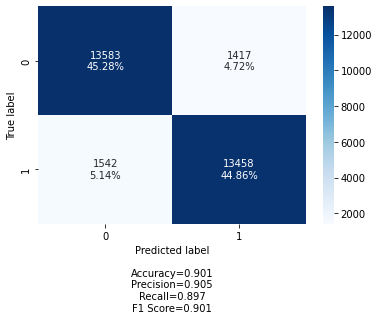

In [ ]:
make_confusion_matrix(confusion_matrix(y_test, y_pred_log))

# Artificial Neural Networks

In [ ]:
!pip3 install tensorflow_text>=2.0.0rc0

In [ ]:
import tensorflow as tf 
import tensorflow_hub as hub
import tensorflow_text
from keras.layers import Dense, Conv1D, Flatten, MaxPooling1D

In [ ]:
y_test = y_test.replace({"Good": 1, "Bad": 0})
y_train = y_train.replace({"Good": 1, "Bad": 0})

 Get tensor flow objects inputs to feed our ANN

In [ ]:
train_tf = tf.data.Dataset.from_tensor_slices((X_train,y_train))
test_tf =  tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [ ]:
next(iter(train_tf.batch(10)))

(<tf.Tensor: shape=(10,), dtype=string, numpy=
 array([b'absolutely best pickle importantly best size pickle tiny little chunk mean dont gag big hard chunk veg cheese pickle sarnie typical british delicacy bread toast butter sharp cheese spread thinly tangy sweet delicious',
        b'chocolate melt thing didnt make enjoyable try pry daughter',
        b'bitter tastealso weird float stuff 5 bottle',
        b'snack great break tooth fill corn nut corn rock',
        b'great bold flavor make one 8oz button add two tsp sugar creamer joes italian roast really help wake morning since wake something can not would suggest friend anyone hard time get morning',
        b'provenal spent first twenty year life marseille delighted product smell wonderful taste excellent mix pinch tea puehr white tea mostly enhances flavor definitely buy',
        b'didnt like',
        b'normally love l l brownie gross flavor ate wont reorder particular flavor',
        b'bread bad ive husband diabetic eat anythi

We will use "nnlm-en-dim50" trained on English Google News 7B corpus to vectorize our own corpus 

In [ ]:
model = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(model, input_shape=[], dtype=tf.string, trainable=True)

# ANN

We can define our first dense neural network architecture

In [ ]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 50)                48190600  
                                                                 
 dense (Dense)               (None, 128)               6528      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 32)                4128      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 48,201,289
Trainable params: 48,201,289
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_tf.shuffle(10000).batch(512),
                    epochs=10,
                    #validation_data=validate_tf.batch(512),
                    verbose=1
                    
                    )

Epoch 1/10
235/235 [==============================] - 80s 328ms/step - loss: 0.3628 - accuracy: 0.8176
Epoch 2/10
235/235 [==============================] - 60s 257ms/step - loss: 0.2535 - accuracy: 0.8951
Epoch 3/10
235/235 [==============================] - 61s 260ms/step - loss: 0.2314 - accuracy: 0.9050
Epoch 4/10
235/235 [==============================] - 64s 273ms/step - loss: 0.2160 - accuracy: 0.9113
Epoch 5/10
235/235 [==============================] - 59s 253ms/step - loss: 0.2024 - accuracy: 0.9170
Epoch 6/10
235/235 [==============================] - 59s 251ms/step - loss: 0.1895 - accuracy: 0.9227
Epoch 7/10
235/235 [==============================] - 59s 252ms/step - loss: 0.1768 - accuracy: 0.9283
Epoch 8/10
235/235 [==============================] - 59s 250ms/step - loss: 0.1661 - accuracy: 0.9321
Epoch 9/10
235/235 [==============================] - 59s 252ms/step - loss: 0.1544 - accuracy: 0.9373
Epoch 10/10
235/235 [==============================] - 59s 251ms/step - l

In [ ]:
# Results of dense ANN 
results = model.evaluate(test_tf.batch(512), verbose=2)

for name, value in zip(model.metrics_names, results):
  print("%s: %.3f" % (name, value))

59/59 - 2s - loss: 0.3750 - accuracy: 0.8838 - 2s/epoch - 27ms/step
loss: 0.375
accuracy: 0.884


# CNN

In [ ]:
model_CNN = tf.keras.Sequential()
model_CNN.add(hub_layer)
model_CNN.add(tf.keras.layers.Reshape((1,50)))
model_CNN.add(Conv1D(filters=32, kernel_size=3, activation='relu', padding = 'same'))
model_CNN.add(MaxPooling1D(pool_size=1))
model_CNN.add(Flatten())
model_CNN.add(Dense(10, activation='relu'))
model_CNN.add(Dense(1, activation='sigmoid'))

model_CNN.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 50)                48190600  
                                                                 
 reshape (Reshape)           (None, 1, 50)             0         
                                                                 
 conv1d (Conv1D)             (None, 1, 32)             4832      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1, 32)            0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 10)                330       
                                                      

In [ ]:
model_CNN.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
history_CNN = model_CNN.fit(train_tf.shuffle(10000).batch(512),
                    epochs=10,
                    #validation_data=validate_tf.batch(512),
                    verbose=1)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


235/235 [==============================] - 59s 250ms/step - loss: 0.3127 - accuracy: 0.8817
Epoch 2/10
235/235 [==============================] - 59s 253ms/step - loss: 0.1948 - accuracy: 0.9240
Epoch 3/10
235/235 [==============================] - 59s 250ms/step - loss: 0.1739 - accuracy: 0.9315
Epoch 4/10
235/235 [==============================] - 59s 251ms/step - loss: 0.1555 - accuracy: 0.9389
Epoch 5/10
235/235 [==============================] - 58s 249ms/step - loss: 0.1403 - accuracy: 0.9462
Epoch 6/10
235/235 [==============================] - 59s 249ms/step - loss: 0.1276 - accuracy: 0.9519
Epoch 7/10
235/235 [==============================] - 59s 251ms/step - loss: 0.1162 - accuracy: 0.9570
Epoch 8/10
235/235 [==============================] - 58s 247ms/step - loss: 0.1065 - accuracy: 0.9611
Epoch 9/10
235/235 [==============================] - 58s 248ms/step - loss: 0.0974 - accuracy: 0.9651
Epoch 10/10
235/235 [==============================] - 58s 246ms/step - loss: 0.0894

In [ ]:
# Results of CNN 
results_CNN = model_CNN.evaluate(test_tf.batch(512), verbose=2)

for name, value in zip(model_CNN.metrics_names, results_CNN):
  print("%s: %.3f" % (name, value))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


59/59 - 2s - loss: 0.4939 - accuracy: 0.8752 - 2s/epoch - 28ms/step
loss: 0.494
accuracy: 0.875


# RNN

In [ ]:
model_RNN = tf.keras.Sequential()
model_RNN.add(hub_layer)
model_RNN.add(tf.keras.layers.Reshape((1,50)))
model_RNN.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)))
model_RNN.add(tf.keras.layers.Dense(64, activation='relu'))
model_RNN.add(tf.keras.layers.Dropout(0.5))
model_RNN.add(tf.keras.layers.Dense(1))
model_RNN.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 50)                48190600  
                                                                 
 reshape_1 (Reshape)         (None, 1, 50)             0         
                                                                 
 bidirectional (Bidirectiona  (None, 128)              58880     
 l)                                                              
                                                                 
 dense_5 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                      

In [ ]:
model_RNN.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
history_RNN = model_RNN.fit(train_tf.shuffle(10000).batch(512),
                    epochs=10,
                    #validation_data=validate_tf.batch(512),
                    verbose=1)

Epoch 1/10
235/235 [==============================] - 66s 267ms/step - loss: 0.2559 - accuracy: 0.8800
Epoch 2/10
235/235 [==============================] - 63s 269ms/step - loss: 0.1646 - accuracy: 0.9282
Epoch 3/10
235/235 [==============================] - 63s 269ms/step - loss: 0.1420 - accuracy: 0.9366
Epoch 4/10
235/235 [==============================] - 62s 263ms/step - loss: 0.1240 - accuracy: 0.9468
Epoch 5/10
235/235 [==============================] - 66s 279ms/step - loss: 0.1100 - accuracy: 0.9542
Epoch 6/10
235/235 [==============================] - 67s 283ms/step - loss: 0.1003 - accuracy: 0.9589
Epoch 7/10
235/235 [==============================] - 63s 270ms/step - loss: 0.0916 - accuracy: 0.9635
Epoch 8/10
235/235 [==============================] - 86s 368ms/step - loss: 0.0859 - accuracy: 0.9662
Epoch 9/10
235/235 [==============================] - 63s 268ms/step - loss: 0.0812 - accuracy: 0.9682
Epoch 10/10
235/235 [==============================] - 65s 278ms/step - l

In [ ]:
# Résultats du RNN
results_RNN = model.evaluate(test_tf.batch(512), verbose=2)

for name, value in zip(model_RNN.metrics_names, results_RNN):
  print("%s: %.3f" % (name, value))

59/59 - 2s - loss: 0.6637 - accuracy: 0.8746 - 2s/epoch - 26ms/step
loss: 0.664
accuracy: 0.875


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Projection on the Twitter database of commercial airlines tweets


In [ ]:
tweet = pd.read_csv('/content/drive/MyDrive/Tweets.csv')
tweet.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [ ]:
df2 = tweet[['airline_sentiment','text']]
df2.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


In [ ]:
df2['airline_sentiment'] = df2['airline_sentiment'].str.replace('positive', 'Good')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df2['airline_sentiment'] = df2['airline_sentiment'].str.replace('negative', 'Bad')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df2['airline_sentiment'] = df2['airline_sentiment'].str.replace('neutral', 'Neutral')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
len(df2)

14640

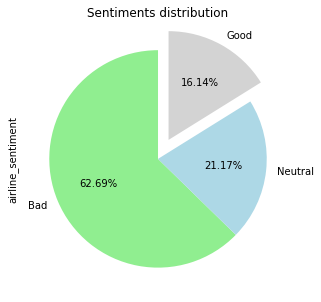

In [ ]:
my_explode=(0,0,0.2)
my_colors=['lightgreen','lightblue','lightgrey']
df2['airline_sentiment'].value_counts().plot.pie(title = "Sentiments distribution", autopct='%1.2f%%', 
                                               startangle = 90, colors = my_colors, explode = my_explode, 
                                               figsize = (5,5), fontsize = 10)

In [ ]:
df2 = df2[df2.airline_sentiment != "Neutral"]

In [ ]:
df2 = df2.dropna()

In [ ]:
def remover(phrase, character_list):

    words = phrase.split()

    for word in words:
        if any(character in word for character in character_list):
            
            words.remove(word)

    new_phrase = ' '.join(words)

    return new_phrase

In [ ]:
df2['reviewText'] = df2['text'].apply(lambda x: remover(x, ['@', '#','http']))

In [ ]:
df2.head()

,airline_sentiment,text,reviewText
1,Good,@VirginAmerica plus you've added commercials t...,plus you've added commercials to the experienc...
3,Bad,@VirginAmerica it's really aggressive to blast...,"it's really aggressive to blast obnoxious ""ent..."
4,Bad,@VirginAmerica and it's a really big bad thing...,and it's a really big bad thing about it
5,Bad,@VirginAmerica seriously would pay $30 a fligh...,seriously would pay $30 a flight for seats tha...
6,Good,"@VirginAmerica yes, nearly every time I fly VX...","yes, nearly every time I fly VX this “ear worm..."


In [ ]:
df2 = ReviewProcessing(df2)

In [ ]:
df2.head()

,airline_sentiment,text,reviewText,review_cleaned
1,Good,@VirginAmerica plus you've added commercials t...,plus you've added commercials to the experienc...,"[plus, youve, added, commercials, experience, ..."
3,Bad,@VirginAmerica it's really aggressive to blast...,"it's really aggressive to blast obnoxious ""ent...","[really, aggressive, blast, obnoxious, enterta..."
4,Bad,@VirginAmerica and it's a really big bad thing...,and it's a really big bad thing about it,"[really, big, bad, thing]"
5,Bad,@VirginAmerica seriously would pay $30 a fligh...,seriously would pay $30 a flight for seats tha...,"[seriously, would, pay, 30, flight, seats, did..."
6,Good,"@VirginAmerica yes, nearly every time I fly VX...","yes, nearly every time I fly VX this “ear worm...","[yes, nearly, every, time, fly, vx, ear, worm,..."


In [ ]:
%%time
df2.review_cleaned = df2.review_cleaned.apply(' '.join)
df2['review_cleaned_lemmatized'] = df2.review_cleaned.apply(get_lemmatize)

CPU times: user 17.2 s, sys: 780 ms, total: 18 s
Wall time: 17.9 s


In [ ]:
df2.head()

,airline_sentiment,text,reviewText,review_cleaned,review_cleaned_lemmatized
1,Good,@VirginAmerica plus you've added commercials t...,plus you've added commercials to the experienc...,plus youve added commercials experience tacky,plus youve add commercial experience tacky
3,Bad,@VirginAmerica it's really aggressive to blast...,"it's really aggressive to blast obnoxious ""ent...",really aggressive blast obnoxious entertainmen...,really aggressive blast obnoxious entertainmen...
4,Bad,@VirginAmerica and it's a really big bad thing...,and it's a really big bad thing about it,really big bad thing,really big bad thing
5,Bad,@VirginAmerica seriously would pay $30 a fligh...,seriously would pay $30 a flight for seats tha...,seriously would pay 30 flight seats didnt play...,seriously would pay 30 flight seat didnt play ...
6,Good,"@VirginAmerica yes, nearly every time I fly VX...","yes, nearly every time I fly VX this “ear worm...",yes nearly every time fly vx ear worm wont go ...,yes nearly every time fly vx ear worm wont go ...


In [ ]:
x2 = df2['review_cleaned_lemmatized']
y2 = df2['airline_sentiment']

In [ ]:
y_pred_log2 = logreg.predict(x2)

In [ ]:
print("Accuracy score on airlines tweets : " + str(accuracy_score(y2, y_pred_log2)))

Accuracy score on airlines tweets : 0.7496750714842735


In [ ]:
logreg.predict(["the plane was 5 minutes ahead"])[0]

'Good'

In [ ]:
logreg.predict(["the plane was 5 minutes late"])[0]

'Bad'

# Projection to neural networks
We keep the weights of the models trained on the Amazon database, and we replace the inputs by the vectorized airline tweets

In [ ]:
x2_test = x2
y2_test = y2

In [ ]:
y2_test = y2_test.replace({"Good": 1, "Bad": 0})
test_tf2 =  tf.data.Dataset.from_tensor_slices((x2_test,y2_test))

In [ ]:
# Results of ANN dense
results = model.evaluate(test_tf2.batch(512), verbose=2)

for name, value in zip(model.metrics_names, results):
  print("%s: %.3f" % (name, value))

23/23 - 1s - loss: 2.8980 - accuracy: 0.6779 - 585ms/epoch - 25ms/step
loss: 2.898
accuracy: 0.678


In [ ]:
# Results of CNN 
results_CNN = model_CNN.evaluate(test_tf2.batch(512), verbose=2)

for name, value in zip(model_CNN.metrics_names, results_CNN):
  print("%s: %.3f" % (name, value))

23/23 - 1s - loss: 2.1120 - accuracy: 0.6837 - 581ms/epoch - 25ms/step
loss: 2.112
accuracy: 0.684


In [ ]:
# Results of RNN
results_RNN = model.evaluate(test_tf2.batch(512), verbose=2)

for name, value in zip(model_RNN.metrics_names, results_RNN):
  print("%s: %.3f" % (name, value))

23/23 - 1s - loss: 2.8980 - accuracy: 0.6779 - 590ms/epoch - 26ms/step
loss: 2.898
accuracy: 0.678


We didn't succeed to outperform the performance of the logistic  with our different ANN.
However, the performance of the sentiment classifier are relatively good.